<a href="https://colab.research.google.com/github/mateopolancecofficial/NLP/blob/main/WineReviews/BERTTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q -U tensorflow-text

     |████████████████████████████████| 3.4MB 6.0MB/s 


In [3]:
pip install -q -U tf-models-official

     |████████████████████████████████| 1.1MB 6.0MB/s 
     |████████████████████████████████| 706kB 16.0MB/s 
     |████████████████████████████████| 1.2MB 19.9MB/s 
     |████████████████████████████████| 37.6MB 98kB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 358kB 47.6MB/s 
     |████████████████████████████████| 645kB 37.3MB/s 
     |████████████████████████████████| 174kB 39.7MB/s 


In [4]:
pip install -U tfds-nightly

     |████████████████████████████████| 3.9MB 4.9MB/s 


In [5]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [6]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [7]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


In [8]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


In [9]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


In [10]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [11]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [12]:
import pandas as pd
import numpy as np

In [13]:
!git clone -l -s https://github.com/mateopolancecofficial/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 8), reused 21 (delta 5), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [14]:
df = pd.read_csv("/content/NLP/WineReviews/data/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [16]:
df = df[['description', 'points']]
df.tail()

,description,points
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90
129970,"Big, rich and off-dry, this is powered by inte...",90


In [17]:
df = df.sample(frac = 1)
df.head()

,description,points
42441,"Straightforward and refined, this presents a f...",88
88360,A red color and a bouquet equal to a cloud of ...,90
49007,There is an almost tropical touch to the apple...,89
62032,"Largely tannic and bearing a lot of oak, Amado...",86
92193,Barrel fermented and aged for 14 months in Fre...,87


In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0


In [19]:
df.description = df.description.str.replace('\d+', '')

In [20]:
from sklearn.model_selection import train_test_split

text_train, text_val, y_train, y_val = train_test_split(df.description, df.points,
                                                  test_size=0.2,train_size=0.8)

In [21]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [22]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_train[:3])

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (3, 128)
Word Ids   : [ 101 2348 2023 9231 4140 2003 1037 2978 4857 1010 2009 2515]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [24]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(3, 768)
Pooled Outputs Values:[-0.86323565 -0.41913536 -0.9746135   0.84291947  0.8230999  -0.10019462
  0.7659029   0.32331616 -0.9228346  -0.99999225 -0.6626903   0.9459754 ]
Sequence Outputs Shape:(3, 128, 768)
Sequence Outputs Values:[[-0.25028375 -0.02637317  0.27427584 ... -0.31557667  0.355242
   0.26920494]
 [-0.7152833  -0.11568587  0.06128956 ...  0.05420844  0.39832982
   0.80754423]
 [-0.20714134  0.21230173  0.14493084 ... -0.15702341  0.34166157
   0.19272964]
 ...
 [ 0.65784323  0.30828428 -0.08690421 ... -0.27100635 -0.5275552
  -0.20775793]
 [-0.05820243  0.37832415 -0.01221382 ...  0.02763999 -0.14573857
   0.23552123]
 [-0.03046327 -0.09521861  0.49324265 ... -0.21626751  0.60497624
  -0.43298793]]


In [36]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(32, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='regressor')(net)
  return tf.keras.Model(text_input, net)

In [37]:
model = build_model()

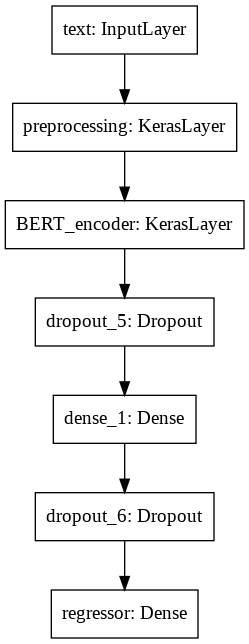

In [38]:
tf.keras.utils.plot_model(model)

In [45]:
loss = 'mean_squared_error'
metrics = 'mean_squared_error'

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256
seed = 42

train_dataset = tf.data.Dataset.from_tensor_slices((text_train, y_train))
train_dataset = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((text_val, y_val))
val_dataset = val_dataset.batch(batch_size)

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [46]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
 78/407 [====>.........................] - ETA: 34:41 - loss: 7543.6207 - mean_squared_error: 7543.6207